# Van der Pol Syllables

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import product
from functools import partial
from copy import copy

from dynamical_systems import Watery, airflow
from numerical_syllables import *
from aux_functions_manual import *

We consider the following system of equations
$$
\begin{cases}
\dot{x} \propto y - (x^2 - x^3 + x^5), \\
\dot{y} \propto \epsilon (a - x)
\end{cases}
$$
which have a fixed point at $(x_0,y_0)=(a, a^2-a^3+a^5)$. We assume $0<\epsilon<<1$.

The bifurcation (from having a stable spiral close to the origin to relaxation oscillations) occurs when $a$ goes from positive to negative.

There is also a region of positive $(a_\min, a_\max)\subset \mathbb{R}^+$, depending on $\epsilon$, where there is multistability (depending on the initial conditions the trajectory is a spiral or relaxation oscillations)

## Preliminaries

### Integration parameters

In [2]:
t0 = 0                  # Initial trajectory time
tf = 10                  # Final trajectory time 

# Use subsample=1 or 8 for testing (fast, low resolution), and 40 for high resolution.
# subsample = 1
# subsample = 8
subsample = 40

step = 1/(subsample * 44150.0)      # timestep

save = True if subsample == 40 else False

In [3]:
trange = np.arange(t0,tf,step)

### Equation parameters

In [4]:
eps = 0.0278    # CHANGE THIS TO MOVE THE SPECTRUM
y0 = (0,0)

# type = "slow"
type = "fast"

convolution = True # If true, multiply the parameter times the solution 

In [5]:
def a_function(t, height=-2*1e6/600, lambda1=3, lambda2=3, T1=7, T2=3):
    
    return 10*(height * airflow(t, lambda1, lambda2, T1, T2) + 0.01)

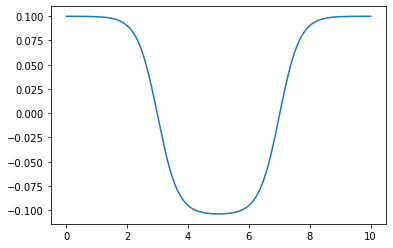

In [6]:
plt.plot(trange,[a_function(t) for t in trange])

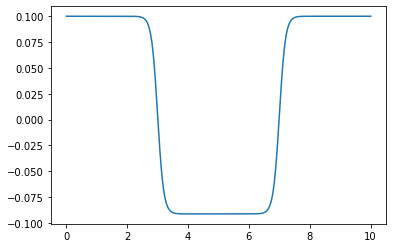

In [7]:
if type == "fast":
    a_function = partial(a_function, height=-4.5*1e15, lambda1=10, lambda2=10) # fast
    plt.plot(trange,[a_function(t) for t in trange])

## Solution and plots

In [8]:
sol = RK45_vdp(partial(Watery, prop=200000), y0, t0, tf, step, eps, a_function)

In [9]:
xspace = np.linspace(-1.4,1.1)
ynull = xspace**2 - xspace**3 + xspace**5

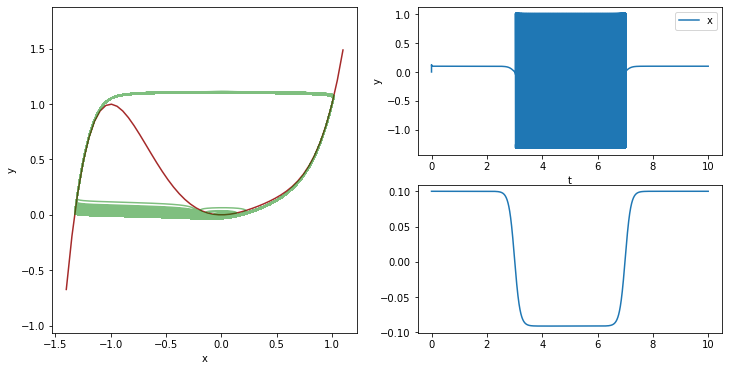

In [10]:
fig = plt.figure(figsize=(12, 6))
ax0 = plt.subplot(1,2,1)
ax1 = plt.subplot(2,2,2)
ax2 = plt.subplot(2,2,4)
ax = [ax0, ax1, ax2]

ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax0.axis('equal')

ax0.plot(xspace,ynull, color="brown")

ax1.set_xlabel('t')
ax1.set_ylabel('y')
#ax1.set_ylabel('x,y')

ax0.plot(sol.y[0], sol.y[1], alpha=0.5, color="green")
ax1.plot(sol.t, sol.y[0], label="x")
#ax1.plot(sol.t, sol.y[1], label="y")

ax2.plot(sol.t, [a_function(t) for t in sol.t])

ax1.legend()

In [11]:
tsol = sol.t[0::subsample]
xsol = sol.y[0][0::subsample]
ysol = sol.y[1][0::subsample]

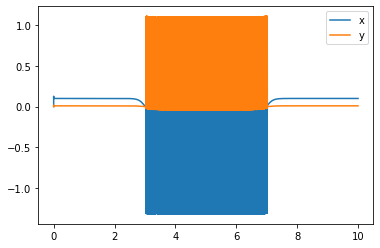

In [12]:
plt.plot(tsol, xsol, label="x")
plt.plot(tsol, ysol, label="y")
plt.legend()

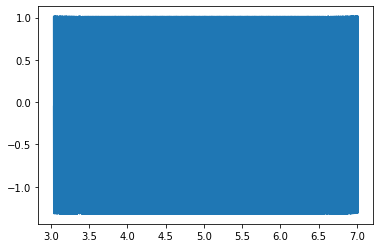

In [13]:
start = np.argmax(xsol > 0.5)
end = np.argmax(xsol[::-1] > 0.5)
window = [start-10,10-end]
xwindow = xsol[window[0]:window[1]]
twindow = tsol[window[0]:window[1]]
plt.plot(twindow, xwindow)

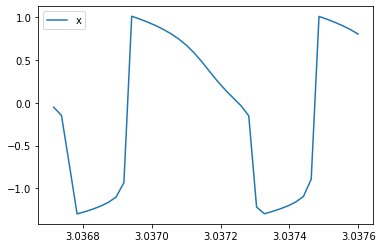

In [14]:
plt.plot(twindow[0:40], xwindow[0:40], label="x")
plt.legend()

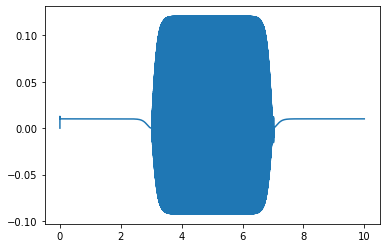

In [15]:
if convolution:
    aperture = np.array([a_function(t) for t in tsol])
    area = 1 - (aperture + 1)/2 # the aperture is what matters in VdP
    xsol = np.multiply(aperture,xsol)
    plt.plot(tsol, xsol)

In [16]:
if save:
    print("Saving solution")
    import pickle
    if type == "fast":
        with open("Output/VdP_xsol.pkl", 'wb') as f:
            pickle.dump({"tsol":tsol, "xsol":xsol}, f)
    elif type == "slow":
        with open("Output/VdP_slow_xsol.pkl", 'wb') as f:
            pickle.dump({"tsol":tsol, "xsol":xsol}, f)
else:
    print("Solution not saved")

Saving solution


## Spectrum

In [17]:
from scipy.fft import fft, fftfreq, fftshift

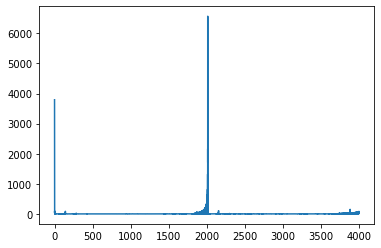

In [18]:
xf = fftfreq(len(xsol), step * subsample)[:len(xsol)//2]
yf = fft(xsol)
spectrum = np.abs(yf)[:len(xsol)//2]
plt.plot(xf[:40000], spectrum[:40000])

## Audio

In [17]:
from IPython.display import Audio
Audio(xsol, rate=int(1/(subsample*step)))

In [18]:
from scipy.io.wavfile import write

rate = int(1/(subsample*step))
scaled = np.int16(xsol / np.max(np.abs(xsol)) * 32767)
#write('Output/VdP.wav', rate, scaled)